In [ ]:
!apt-get update
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
!pip install pyvista[jupyter]
# !pip install cupy-cuda12x  # adjust version (12x) based on your CUDA installation
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"  # For CPU

# For GPU (recommended if you have a GPU runtime):
# !pip install --upgrade "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,798 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [33.2 kB]
Get:13 http://securit

In [ ]:
import numpy as np

# -----------------------------
# Simulation / Physical Parameters
# -----------------------------
Nx, Ny, Nz = 6*16, 6*16, 6*16    # Number of lattice points along x,y,z
# Nx, Ny, Nz = 21, 21, 21
dx = 0.25              # Spacing between lattice sites
Lx = Nx * dx               # Physical length in x-direction
Ly = Ny * dx
Lz = Nz * dx


R_bound_sphere = 10                       # In physical coordinates
mu_z = 5*5                # Magnitude of the dipole along z: mu = (0,0, mu_z)
# T_initial = 10     # Starting 'temperature' for simulated annealing
# reduction_factor = 0.99     # Factor to reduce T each step
# steps_per_T = 40          # Monte Carlo sweeps at each T
# max_annealing_steps = 1000   # Max number of temperature-lowering steps
# tolerance = 1e-5           # Convergence threshold (relative change in F)

In [ ]:
import jax.numpy as jnp
def initial_psi_linear(N, a, phi0, Nx, Ny, Nz, dx):
    """
    Initializes Delta_init with amplitude linearly dependent on radius r,
    peaking at radius a and vanishing at r=0 and at the boundaries, modulated
    angularly by cos(N*(phi - phi0))-1.

    Parameters:
    -----------
    N      : int, number of azimuthal oscillations
    a      : float, radius at which amplitude peaks
    phi0   : float, reference azimuth angle
    Nx,Ny,Nz : int, dimensions of the lattice
    dx     : float, grid spacing

    Returns:
    --------
    Delta_init : ndarray shape (Nx, Ny, Nz, 2), complex wavefunction
    """

    Delta_init = np.zeros((Nx, Ny, Nz, 2), dtype=float)

    # center coordinates
    cx = Nx / 2 - 0.5
    cy = Ny / 2 - 0.5
    cz = Nz / 2 - 0.5

    # maximum amplitude
    amplitude = 0.1

    # Maximum radial extent (to boundaries)
    max_r = min(Nx, Ny, Nz) * dx / 2

    for ix in range(Nx):
        for iy in range(Ny):
            for iz in range(Nz):
                # Convert indices to Cartesian coordinates
                x = (ix - cx) * dx
                y = (iy - cy) * dx
                z = (iz - cz) * dx

                # Spherical coordinates
                r = np.sqrt(x**2 + y**2 + z**2)
                theta = np.arccos(z / (r + 1e-12))  # avoid division by zero
                phi = np.arctan2(y, x)

                # Radial dependence (linear up to a, then linear decay)
                if r <= a:
                    radial_amp = amplitude * (r / a)
                elif r <= max_r:
                    radial_amp = amplitude * (1 - (r - a) / (max_r - a))
                else:
                    radial_amp = 0.0

                # Angular dependence
                angular_amp = np.cos(N * (phi - phi0)) - 1

                # Real and imaginary parts
                Delta_init[ix, iy, iz, 0] = radial_amp * angular_amp
                Delta_init[ix, iy, iz, 1] = radial_amp * np.sin(N * (phi - phi0))

                # if r > R_bound_sphere:
                #      Delta_init[ix, iy, iz, 0] = 0
                #      Delta_init[ix, iy, iz, 1] = 1

    return Delta_init

def initial_psiN(N, a0, phi0, Nx, Ny, Nz, dx):
    """
    Create an initial wavefunction array Delta_init[ix,iy,iz,0 or 1]
    that vanishes along N symmetric loops of radius a0 around the z-axis.

    Parameters:
    -----------
      N       : number of nodal loops.
      a0      : target radius (distance from z-axis) at which we want loops.
      phi0    : reference azimuth for the loops' positioning.
      Nx,Ny,Nz: lattice dimensions in x, y, z.
      dx      : spacing of lattice points (assuming uniform spacing).

    Returns:
    --------
      Delta_init : ndarray of shape (Nx, Ny, Nz, 2),
                   where Delta_init[...,0] = Re(ψ), Delta_init[...,1] = Im(ψ).
    """
    Delta_init = np.zeros((Nx, Ny, Nz, 2), dtype=float)

    # Center the box so that (ix,iy,iz) = (Nx/2, Ny/2, Nz/2) corresponds to (x,y,z) = (0,0,0).
    cx = Nx / 2.0 - 0.5
    cy = Ny / 2.0 - 0.5
    cz = Nz / 2.0 - 0.5

    amplitude = 0.4  # small overall prefactor
    max_r = min(Nx, Ny, Nz) * dx / 2

    for ix in range(Nx):
        for iy in range(Ny):
            for iz in range(Nz):
                # Real-space coordinates
                x = (ix - cx) * dx
                y = (iy - cy) * dx
                z = (iz - cz) * dx

                # Convert to cylindrical coords
                a = np.sqrt(x*x + y*y)       # radial distance from z-axis
                phi = np.arctan2(y, x)       # azimuth angle around z-axis

                # Real part => (a - a0)
                if a <= a0:
                    radial_amp = amplitude * (a / a0)
                elif a <= max_r:
                    radial_amp = amplitude * (1 - (a - a0) / (max_r - a))
                else:
                    radial_amp = 0.0
                re_psi = (a - a0 + np.cos(N * (phi - phi0)) - 1)

                # Imag part => sin[N * (phi - phi0)]
                im_psi = np.sin(N * (phi - phi0))

                # Combine and scale
                Delta_init[ix, iy, iz, 0] = amplitude * re_psi
                Delta_init[ix, iy, iz, 1] = amplitude * im_psi

    return Delta_init


N_loops = 3       # we want N=3 nodal loops
a0     = 5.0      # choose the loop radius
phi0   = 0.0      # reference azimuth
Delta_init = initial_psi_linear(N_loops, a0, phi0, Nx, Ny, Nz, dx)
Delta_init = jnp.asarray(Delta_init)


In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
# Delta_init = np.load(f"Delta_final_mu_{int(mu_z)}_{Nx*Nx*Nx}.{dx}.npy")

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, lax
from functools import partial
import matplotlib.pyplot as plt
import time

# --- Your provided functions (unchanged) ---
# dx = 1.0
# mu_z = 1.0

def compute_free_energy_jax(Delta):
    Nx, Ny, Nz, _ = Delta.shape
    psi = Delta[..., 0] + 1j * Delta[..., 1]
    abs_sq = jnp.abs(psi)**2
    F_pot = -abs_sq + 0.5 * abs_sq**2
    F_kin = jnp.zeros_like(abs_sq)
    alpha_x = phase_link_vectorized_jax('x', Delta)
    alpha_y = phase_link_vectorized_jax('y', Delta)
    alpha_z = phase_link_vectorized_jax('z', Delta)
    alphas = [alpha_x, alpha_y, alpha_z]
    for dir_idx, alpha in enumerate(alphas):
        psi_shifted = jnp.roll(psi, shift=-1, axis=dir_idx)
        psi_phased = psi * jnp.exp(1j * alpha)
        diff = psi_shifted - psi_phased
        F_kin = F_kin + jnp.abs(diff)**2
    F_total = F_pot + F_kin
    return jnp.mean(F_total)

def phase_link_vectorized_jax(direction, Delta):
    Nx, Ny, Nz, _ = Delta.shape
    ix, iy, iz = jnp.meshgrid(
        jnp.arange(Nx), jnp.arange(Ny), jnp.arange(Nz), indexing='ij'
    )
    x = (ix - Nx / 2 + 0.5) * dx
    y = (iy - Ny / 2 + 0.5) * dx
    z = (iz - Nz / 2 + 0.5) * dx
    if direction == 'x':
        xn, yn, zn = x + dx/2, y, z
    elif direction == 'y':
        xn, yn, zn = x, y + dx/2, z
    else:  # 'z'
        xn, yn, zn = x, y, z + dx/2
    r_sq = xn**2 + yn**2 + zn**2
    r_1_5 = jnp.where(r_sq < 1e-12, 1e12, 1.0 / r_sq**1.5)
    Ax = -mu_z * yn * r_1_5
    Ay = mu_z * xn * r_1_5
    if direction == 'x':
        alpha = Ax * dx
    elif direction == 'y':
        alpha = Ay * dx
    else:
        alpha = jnp.zeros_like(Ax)
    return alpha


In [ ]:
%time compute_free_energy_jax(Delta_init)

CPU times: user 158 ms, sys: 40.9 ms, total: 199 ms
Wall time: 188 ms


Array(-0.0023296, dtype=float32)

In [ ]:
# -----------------------------------------------------------------------------
# 1. Core dE Calculation (Slightly cleaner)
# -----------------------------------------------------------------------------
def _compute_energy_change(psi_grid, alpha_phases, ix, iy, iz, psi_new):
    """Computes the change in energy dE if psi at (ix,iy,iz) changes."""
    Nx, Ny, Nz = psi_grid.shape
    alpha_x, alpha_y, alpha_z = alpha_phases
    psi_old = psi_grid[ix, iy, iz]

    dF_pot = (-jnp.abs(psi_new)**2 + 0.5 * jnp.abs(psi_new)**4) - \
             (-jnp.abs(psi_old)**2 + 0.5 * jnp.abs(psi_old)**4)
    dF_kin = 0.0

    # Interaction with forward neighbors: i -> i+1
    dF_kin += jnp.abs(psi_grid[(ix+1)%Nx, iy, iz] - psi_new * jnp.exp(1j*alpha_x[ix,iy,iz]))**2 - \
              jnp.abs(psi_grid[(ix+1)%Nx, iy, iz] - psi_old * jnp.exp(1j*alpha_x[ix,iy,iz]))**2
    dF_kin += jnp.abs(psi_grid[ix, (iy+1)%Ny, iz] - psi_new * jnp.exp(1j*alpha_y[ix,iy,iz]))**2 - \
              jnp.abs(psi_grid[ix, (iy+1)%Ny, iz] - psi_old * jnp.exp(1j*alpha_y[ix,iy,iz]))**2
    dF_kin += jnp.abs(psi_grid[ix, iy, (iz+1)%Nz] - psi_new * jnp.exp(1j*alpha_z[ix,iy,iz]))**2 - \
              jnp.abs(psi_grid[ix, iy, (iz+1)%Nz] - psi_old * jnp.exp(1j*alpha_z[ix,iy,iz]))**2

    # Interaction with backward neighbors: i-1 -> i
    ixm, iym, izm = (ix-1+Nx)%Nx, (iy-1+Ny)%Ny, (iz-1+Nz)%Nz
    dF_kin += jnp.abs(psi_new - psi_grid[ixm,iy,iz] * jnp.exp(1j*alpha_x[ixm,iy,iz]))**2 - \
              jnp.abs(psi_old - psi_grid[ixm,iy,iz] * jnp.exp(1j*alpha_x[ixm,iy,iz]))**2
    dF_kin += jnp.abs(psi_new - psi_grid[ix,iym,iz] * jnp.exp(1j*alpha_y[ix,iym,iz]))**2 - \
              jnp.abs(psi_old - psi_grid[ix,iym,iz] * jnp.exp(1j*alpha_y[ix,iym,iz]))**2
    dF_kin += jnp.abs(psi_new - psi_grid[ix,iy,izm] * jnp.exp(1j*alpha_z[ix,iy,izm]))**2 - \
              jnp.abs(psi_old - psi_grid[ix,iy,izm] * jnp.exp(1j*alpha_z[ix,iy,izm]))**2

    return dF_pot + dF_kin

# vmap over a flattened grid
_vmap_compute_energy_change = jax.vmap(_compute_energy_change, in_axes=(None, None, 0, 0, 0, 0))


# -----------------------------------------------------------------------------
# 2. Single-Parity Update (FIXED)
# -----------------------------------------------------------------------------
@partial(jax.jit, static_argnums=(4,)) # Static `parity` is good!
def _update_parity(Delta, key, T, delta, parity, alpha_phases):
    """
    Update all sites with (i+j+k)%2 == parity using full-grid masking.
    """
    Nx, Ny, Nz, _ = Delta.shape
    psi_grid = Delta[..., 0] + 1j * Delta[..., 1]

    # --- 1. Propose moves for the ENTIRE grid ---
    key, subkey1, subkey2 = random.split(key, 3)
    dreal = delta * random.normal(subkey1, psi_grid.shape)
    dimag = delta * random.normal(subkey2, psi_grid.shape)
    psi_prop_grid = psi_grid + (dreal + 1j * dimag)

    # --- 2. Calculate dE for the ENTIRE grid ---
    # To vmap over the grid, we need flattened coordinates and values
    ix_flat, iy_flat, iz_flat = jnp.meshgrid(jnp.arange(Nx), jnp.arange(Ny), jnp.arange(Nz), indexing='ij')
    ix_flat, iy_flat, iz_flat = ix_flat.ravel(), iy_flat.ravel(), iz_flat.ravel()
    psi_prop_flat = psi_prop_grid.ravel()

    dE_flat = _vmap_compute_energy_change(psi_grid, alpha_phases, ix_flat, iy_flat, iz_flat, psi_prop_flat)
    dE_grid = dE_flat.reshape(Nx, Ny, Nz)

    # --- 3. Metropolis-Hastings acceptance for the ENTIRE grid ---
    key, subkey3 = random.split(key)
    acceptance_prob = jnp.exp(-dE_grid / T)
    uniform_random = random.uniform(subkey3, dE_grid.shape)
    acceptance_mask = uniform_random < acceptance_prob # Boolean grid

    # --- 4. Selectively apply updates using the parity mask ---
    # Create the checkerboard mask
    ix, iy, iz = jnp.meshgrid(jnp.arange(Nx), jnp.arange(Ny), jnp.arange(Nz), indexing='ij')
    parity_mask = ((ix + iy + iz) % 2) == parity

    # Update a site IFF its parity matches AND the move is accepted
    final_update_mask = parity_mask & acceptance_mask

    # Use jnp.where to choose between the old and proposed values
    psi_final_grid = jnp.where(final_update_mask, psi_prop_grid, psi_grid)

    Delta_new = jnp.stack([psi_final_grid.real, psi_final_grid.imag], axis=-1)
    return Delta_new, key


# -----------------------------------------------------------------------------
# 3. Full Monte Carlo Sweep (Unchanged)
# -----------------------------------------------------------------------------
@jax.jit
def mc_sweep(Delta, key, T, delta, alpha_phases):
    Delta, key = _update_parity(Delta, key, T, delta, parity=0, alpha_phases=alpha_phases)
    Delta, key = _update_parity(Delta, key, T, delta, parity=1, alpha_phases=alpha_phases)
    return Delta, key

# -----------------------------------------------------------------------------
# 4. Simulated Annealing Loop (Unchanged)
# -----------------------------------------------------------------------------
def simulated_annealing(Delta0, key, T0, T1, n_sweeps, delta):
    alpha_x = phase_link_vectorized_jax('x', Delta0)
    alpha_y = phase_link_vectorized_jax('y', Delta0)
    alpha_z = phase_link_vectorized_jax('z', Delta0)
    alpha_phases = (alpha_x, alpha_y, alpha_z)

    def body(carry, i):
        Delta, key = carry
        T = T0 + (T1 - T0) * (i / jnp.maximum(n_sweeps - 1, 1))
        T = jnp.maximum(T, 1e-6)
        Delta, key = mc_sweep(Delta, key, T, delta, alpha_phases)
        energy = compute_free_energy_jax(Delta)
        return (Delta, key), energy

    (Delta_final, _), energy_history = lax.scan(
        body, (Delta0, key), jnp.arange(n_sweeps)
    )
    return Delta_final, energy_history

# -----------------------------------------------------------------------------
# 5. Usage Example (Unchanged)
# -----------------------------------------------------------------------------
# if __name__ == "__main__":
    # System parameters
# Nx, Ny, Nz = 21, 21, 21
# dx = 1.0
# mu_z = 0.5

# Simulation parameters
key = random.PRNGKey(42)
delta = 0.005
T0, T1 = 0.0001, 0.000000001
n_sweeps = 50000

# Initial state
key, subkey = random.split(key)
Delta0 = random.normal(subkey, (Nx, Ny, Nz, 2)) * 0.1

print(f"Starting simulated annealing...")
print(f"Grid: {Nx}x{Ny}x{Nz}, Sweeps: {n_sweeps}, T: {T0} -> {T1}")

start_time = time.time()
Delta_final, energy_history = simulated_annealing(Delta_final, key, T0, T1, n_sweeps, delta)
energy_history.block_until_ready()
end_time = time.time()
print(f"Simulation finished in {end_time - start_time:.2f} seconds.")

F_initial = compute_free_energy_jax(Delta_init)
F_final = energy_history[-1]
print(f"\nInitial free energy: {F_initial:.6f}")
print(f"Final free energy:   {F_final:.6f}")

plt.figure(figsize=(10, 6))
plt.plot(energy_history)
plt.xlabel("MC Sweep")
plt.ylabel("Average Free Energy")
plt.title("Simulated Annealing Energy Profile")
plt.grid(True)
plt.show()


NameError: name 'jax' is not defined

In [ ]:

# import jax
# import jax.numpy as jnp
# from jax import random, lax
# from functools import partial
# import matplotlib.pyplot as plt
# import time

# # --- System Constants ---
# # dx = 1.0
# # mu_z = 1.0

# # --- Core Physics and Utility Functions ---

# def phase_link_vectorized_jax(direction, Delta):
#     Nx, Ny, Nz, _ = Delta.shape
#     ix, iy, iz = jnp.meshgrid(
#         jnp.arange(Nx), jnp.arange(Ny), jnp.arange(Nz), indexing='ij'
#     )
#     x = (ix - Nx / 2 + 0.5) * dx
#     y = (iy - Ny / 2 + 0.5) * dx
#     z = (iz - Nz / 2 + 0.5) * dx
#     if direction == 'x': xn, yn, zn = x + dx/2, y, z
#     elif direction == 'y': xn, yn, zn = x, y + dx/2, z
#     else: xn, yn, zn = x, y, z + dx/2
#     r_sq = xn**2 + yn**2 + zn**2
#     r_1_5 = jnp.where(r_sq < 1e-12, 1e12, 1.0 / r_sq**1.5)
#     Ax = -mu_z * yn * r_1_5
#     Ay = mu_z * xn * r_1_5
#     if direction == 'x': alpha = Ax * dx
#     elif direction == 'y': alpha = Ay * dx
#     else: alpha = jnp.zeros_like(Ax)
#     return alpha

# def compute_free_energy_jax(Delta, alpha_phases):
#     """Computes the average free energy. Accepts pre-computed alpha phases."""
#     Nx, Ny, Nz, _ = Delta.shape
#     psi = Delta[..., 0] + 1j * Delta[..., 1]
#     abs_sq = jnp.abs(psi)**2
#     F_pot = -abs_sq + 0.5 * abs_sq**2
#     F_kin = jnp.zeros_like(abs_sq)
#     for dir_idx, alpha in enumerate(alpha_phases):
#         psi_shifted = jnp.roll(psi, shift=-1, axis=dir_idx)
#         psi_phased = psi * jnp.exp(1j * alpha)
#         diff = psi_shifted - psi_phased
#         F_kin = F_kin + jnp.abs(diff)**2
#     F_total = F_pot + F_kin
#     return jnp.mean(F_total)

# # -----------------------------------------------------------------------------
# # UPDATED Residual Calculation Function
# # -----------------------------------------------------------------------------
# @jax.jit
# def compute_residual_jax(Delta, alpha_phases):
#     """
#     Correctly computes the Euler-Lagrange residual using the gauge-covariant Laplacian.
#     Accepts pre-computed alpha phases for efficiency.
#     """
#     Nx, Ny, Nz, _ = Delta.shape
#     psi = Delta[...,0] + 1j*Delta[...,1]
#     laplacian_term = jnp.zeros_like(psi)
#     alpha_x, alpha_y, alpha_z = alpha_phases

#     # Loop over the 3 directions (x, y, z)
#     for d, alpha in enumerate(alpha_phases):
#         psi_fwd = jnp.roll(psi, shift=-1, axis=d)
#         psi_bwd = jnp.roll(psi, shift=1, axis=d)
#         alpha_at_bwd_site = jnp.roll(alpha, shift=1, axis=d)

#         # Parallel transport neighbors back to the central site
#         term_fwd = jnp.exp(1j * alpha) * psi_fwd
#         term_bwd = jnp.exp(-1j * alpha_at_bwd_site) * psi_bwd

#         # Covariant central difference
#         laplacian_term_d = (term_fwd + term_bwd - 2*psi) / dx**2
#         laplacian_term += laplacian_term_d

#     # Assemble the final residual: -D^2 ψ - ψ + |ψ|^2 ψ = 0
#     residual = laplacian_term - psi + psi * jnp.abs(psi)**2
#     return residual

# # --- Core MC Step Functions ---

# def _compute_energy_change(psi_grid, alpha_phases, ix, iy, iz, psi_new):
#     """Computes the change in energy dE if psi at (ix,iy,iz) changes."""
#     Nx, Ny, Nz = psi_grid.shape
#     alpha_x, alpha_y, alpha_z = alpha_phases
#     psi_old = psi_grid[ix, iy, iz]
#     dF_pot = (-jnp.abs(psi_new)**2 + 0.5 * jnp.abs(psi_new)**4) - \
#              (-jnp.abs(psi_old)**2 + 0.5 * jnp.abs(psi_old)**4)
#     dF_kin = 0.0
#     dF_kin += jnp.abs(psi_grid[(ix+1)%Nx, iy, iz] - psi_new*jnp.exp(1j*alpha_x[ix,iy,iz]))**2 - jnp.abs(psi_grid[(ix+1)%Nx, iy, iz] - psi_old*jnp.exp(1j*alpha_x[ix,iy,iz]))**2
#     dF_kin += jnp.abs(psi_grid[ix, (iy+1)%Ny, iz] - psi_new*jnp.exp(1j*alpha_y[ix,iy,iz]))**2 - jnp.abs(psi_grid[ix, (iy+1)%Ny, iz] - psi_old*jnp.exp(1j*alpha_y[ix,iy,iz]))**2
#     dF_kin += jnp.abs(psi_grid[ix, iy, (iz+1)%Nz] - psi_new*jnp.exp(1j*alpha_z[ix,iy,iz]))**2 - jnp.abs(psi_grid[ix, iy, (iz+1)%Nz] - psi_old*jnp.exp(1j*alpha_z[ix,iy,iz]))**2
#     ixm, iym, izm = (ix-1+Nx)%Nx, (iy-1+Ny)%Ny, (iz-1+Nz)%Nz
#     dF_kin += jnp.abs(psi_new - psi_grid[ixm,iy,iz]*jnp.exp(1j*alpha_x[ixm,iy,iz]))**2 - jnp.abs(psi_old - psi_grid[ixm,iy,iz]*jnp.exp(1j*alpha_x[ixm,iy,iz]))**2
#     dF_kin += jnp.abs(psi_new - psi_grid[ix,iym,iz]*jnp.exp(1j*alpha_y[ix,iym,iz]))**2 - jnp.abs(psi_old - psi_grid[ix,iym,iz]*jnp.exp(1j*alpha_y[ix,iym,iz]))**2
#     dF_kin += jnp.abs(psi_new - psi_grid[ix,iy,izm]*jnp.exp(1j*alpha_z[ix,iy,izm]))**2 - jnp.abs(psi_old - psi_grid[ix,iy,izm]*jnp.exp(1j*alpha_z[ix,iy,izm]))**2
#     return dF_pot + dF_kin

# _vmap_compute_energy_change = jax.vmap(_compute_energy_change, in_axes=(None, None, 0, 0, 0, 0))

# # --- Residual-Biased Monte Carlo Machinery ---

# @partial(jax.jit, static_argnums=(4, 6, 7)) # parity, num_updates, residual_power are static
# def _update_biased_parity(Delta, key, T, delta, parity, residual, num_updates, residual_power, epsilon, alpha_phases):
#     """Selects a subset of sites based on residual weights and updates them."""
#     Nx, Ny, Nz, _ = Delta.shape
#     psi_grid = Delta[..., 0] + 1j * Delta[..., 1]

#     weights = (jnp.abs(residual)**residual_power + epsilon).ravel()
#     ix, iy, iz = jnp.meshgrid(jnp.arange(Nx), jnp.arange(Ny), jnp.arange(Nz), indexing='ij')
#     parity_mask = (((ix + iy + iz) % 2) == parity).ravel()
#     masked_weights = weights * parity_mask
#     prob_dist = masked_weights / jnp.sum(masked_weights)

#     key, subkey = random.split(key)
#     all_indices = jnp.arange(Nx * Ny * Nz)
#     selected_flat_indices = random.choice(subkey, all_indices, shape=(num_updates,), p=prob_dist, replace=False)

#     iux, iuy, iuz = jnp.unravel_index(selected_flat_indices, (Nx, Ny, Nz))

#     key, subkey1, subkey2, subkey3 = random.split(key, 4)
#     psi_old_subset = psi_grid[iux, iuy, iuz]
#     dreal = delta * random.normal(subkey1, (num_updates,))
#     dimag = delta * random.normal(subkey2, (num_updates,))
#     psi_prop_subset = psi_old_subset + (dreal + 1j * dimag)

#     dE = _vmap_compute_energy_change(psi_grid, alpha_phases, iux, iuy, iuz, psi_prop_subset)

#     acceptance_prob = jnp.exp(-dE / T)
#     accept = random.uniform(subkey3, (num_updates,)) < acceptance_prob
#     psi_new_subset = jnp.where(accept, psi_prop_subset, psi_old_subset)

#     psi_final_grid = psi_grid.at[iux, iuy, iuz].set(psi_new_subset)
#     Delta_new = jnp.stack([psi_final_grid.real, psi_final_grid.imag], axis=-1)

#     return Delta_new, key

# @partial(jax.jit, static_argnums=(4, 5, 6)) # num_updates_per_half, residual_power are static
# def mc_sweep_biased(Delta, key, T, delta, num_updates_per_half, residual_power, epsilon, alpha_phases):
#     """Perform one full residual-biased checkerboard MC sweep."""
#     # Calculate residual once per full sweep using the CORRECT function
#     residual = compute_residual_jax(Delta, alpha_phases)

#     Delta, key = _update_biased_parity(Delta, key, T, delta, 0, residual, num_updates_per_half, residual_power, epsilon, alpha_phases)
#     Delta, key = _update_biased_parity(Delta, key, T, delta, 1, residual, num_updates_per_half, residual_power, epsilon, alpha_phases)
#     return Delta, key


# def simulated_annealing_biased(Delta0, key, T0, T1, n_sweeps, delta, sim_params):
#     """Runs simulated annealing using the biased update scheme."""
#     num_updates_per_half = sim_params['num_updates_per_half']
#     residual_power = sim_params['residual_power']
#     epsilon = sim_params['epsilon']

#     alpha_x = phase_link_vectorized_jax('x', Delta0)
#     alpha_y = phase_link_vectorized_jax('y', Delta0)
#     alpha_z = phase_link_vectorized_jax('z', Delta0)
#     alpha_phases = (alpha_x, alpha_y, alpha_z)

#     def body(carry, i):
#         Delta, key = carry
#         T = T0 + (T1 - T0) * (i / jnp.maximum(n_sweeps - 1, 1))
#         T = jnp.maximum(T, 1e-6)
#         Delta, key = mc_sweep_biased(Delta, key, T, delta, num_updates_per_half, residual_power, epsilon, alpha_phases)
#         # Tracking can be added here if desired
#         energy = compute_free_energy_jax(Delta, alpha_phases)
#         max_res = jnp.abs(compute_residual_jax(Delta, alpha_phases)).max()
#         return (Delta, key), (energy, max_res)

#     (Delta_final, _), (energy_history, residual_history) = lax.scan(body, (Delta0, key), jnp.arange(n_sweeps))
#     return Delta_final, energy_history, residual_history

# # Nx, Ny, Nz = 16, 16, 16

# # Simulation parameters
# key = random.PRNGKey(42)
# delta = 0.001
# T0, T1 = 0.0001, 0.000001
# n_sweeps = 2000

# # Biased simulation hyperparameters
# biased_sim_params = {
#     'num_updates_per_half': int(0.2 * (Nx*Ny*Nz/2)), # Update 20% of sites per half-sweep
#     'residual_power': 2.0, # Use |R|^2 for strong bias
#     'epsilon': 1e-9      # Small constant to avoid division by zero
# }

# # Initial state
# key, subkey = random.split(key)
# Delta0 = random.normal(subkey, (Nx, Ny, Nz, 2)) * 0.5

# print("--- Running CORRECTED Residual-Biased Simulation ---")
# print(f"Grid: {Nx}x{Ny}x{Nz}, Sweeps: {n_sweeps}")
# print(f"Updating {biased_sim_params['num_updates_per_half']} sites per half-sweep.")

# start_time = time.time()
# Delta_final, F_hist, R_hist = simulated_annealing_biased(Delta_final, key, T0, T1, n_sweeps, delta, biased_sim_params)
# F_hist.block_until_ready() # Block for accurate timing
# end_time = time.time()
# print(f"Biased simulation finished in {end_time - start_time:.2f} seconds.")

# print(f"\nFinal Free Energy: {F_hist[-1]:.6f}")
# print(f"Final Max Residual |R|: {R_hist[-1]:.2e}")

# # --- Plotting ---
# fig, ax1 = plt.subplots(figsize=(12, 7))

# color = 'tab:blue'
# ax1.set_xlabel('MC Sweep')
# ax1.set_ylabel('Average Free Energy', color=color)
# ax1.plot(F_hist, color=color, label='Free Energy')
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:red'
# ax2.set_ylabel('Max Residual |R|', color=color)
# ax2.plot(R_hist, color=color, label='Max Residual')
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_yscale('log')

# fig.suptitle('Biased Simulated Annealing Performance', fontsize=16)
# fig.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
import jax
# mu_z = 25
# Nx = 6*16
# Ny = 6*16
# Nz = 6*16

# Assuming Delta_final is defined and computed somewhere in your code:
# jax.numpy.save(f"Delta_final_linear_{mu_z}_{Nx*Ny*Nz}.npy", Delta_final)
Delta_final = jax.numpy.load(f"Delta_final_true_linear_{mu_z}_{Nx*Ny*Nz}_{dx}.npy")

In [ ]:
import jax.numpy as jnp
# Assume phase_link_vectorized_jax, dx, etc. are defined elsewhere

def compute_residual_jax(Delta):
    """
    Compute the Euler-Lagrange residual correctly using the gauge-covariant Laplacian:
    D^2 ψ - ψ + ψ|ψ|^2 on the lattice.
    This residual corresponds to the free energy functional in compute_free_energy_jax.
    """
    Nx, Ny, Nz, _ = Delta.shape
    psi = Delta[...,0] + 1j*Delta[...,1]

    # This will accumulate the full Laplacian term: D^2 ψ
    # (D^2 ψ)_j = sum_d [ U_d(j-d)ψ_{j-d} + U_d(j)*ψ_{j+d} - 2ψ_j ]
    laplacian_term = jnp.zeros_like(psi)

    # Pre-compute all alpha phases once for efficiency
    alpha_x = phase_link_vectorized_jax('x', Delta)
    alpha_y = phase_link_vectorized_jax('y', Delta)
    alpha_z = phase_link_vectorized_jax('z', Delta)
    alphas = [alpha_x, alpha_y, alpha_z]

    # Loop over the 3 directions (x, y, z)
    for d, alpha_d in enumerate(alphas):
        # 1. Get psi at forward and backward neighboring sites
        psi_fwd = jnp.roll(psi, shift=-1, axis=d)  # psi(x + e_d)
        psi_bwd = jnp.roll(psi, shift=1, axis=d)   # psi(x - e_d)

        # 2. Get the required link phase alpha at the backward site
        # This is alpha_d(x - e_d), corresponding to the link U_d(x - e_d)
        alpha_d_at_bwd_site = jnp.roll(alpha_d, shift=1, axis=d)

        # 3. Parallel transport the neighbors' psi back to the central site
        # Transport from forward neighbor (x+e_d) -> x uses the INVERSE link U_d(x)*
        term_fwd = jnp.exp(-1j * alpha_d) * psi_fwd

        # Transport from backward neighbor (x-e_d) -> x uses the FORWARD link U_d(x-e_d)
        term_bwd = jnp.exp(1j * alpha_d_at_bwd_site) * psi_bwd

        # 4. Compute the laplacian for this direction and add it to the total
        # The (term_fwd + term_bwd - 2*psi) is the covariant central difference
        # Note: Depending on convention, you might need a minus sign on the whole term.
        # Based on our derivation, the kinetic term in F gives -D^2 in the E-L equation.
        # However, the standard GL equation is written as -D^2 + potential.
        # We will compute D^2 = sum_d (transported_fwd + transported_bwd - 2*psi)
        laplacian_term_d = (term_fwd + term_bwd - 2*psi) # / dx**2 is just a scaling
        laplacian_term += laplacian_term_d

    # Optional: scale by lattice spacing squared
    laplacian_term = laplacian_term / dx**2

    # 5. Assemble the final residual according to the Ginzburg-Landau equation
    # The E-L equation derived from F is: -laplacian_term - psi + |psi|^2 psi = 0
    # Or, written in the more standard form: laplacian_term + psi - |psi|^2 psi = 0
    # Let's stick to the form in the original code's comment: D^2 ψ - ψ + |ψ|^2 ψ
    residual = (laplacian_term - psi + psi * jnp.abs(psi)**2) / jnp.abs(psi)

    # Compute max/min |residual|
    abs_residual = jnp.abs(residual)
    max_res = abs_residual.max()
    min_res = abs_residual.min()

    # Returning the full residual field is useful for the biased MC or minimization
    return residual, max_res, min_res


residual_init, max_res, min_res = compute_residual_jax(Delta_init)
residual, max_res, min_res = compute_residual_jax(Delta_final)

print("Max residual |R|:", float(max_res))
print("Min residual |R|:", float(min_res))


Max residual |R|: 23.32526206970215
Min residual |R|: 7.743459718767554e-05


Running calculations on a 96x96x96 grid...
1. Corrected Analytical solution computed.
2. Corrected Spectral method solution computed.
3. Original Finite-difference method solution computed.

--- Findings ---
The FDM code calculates (∇²+2iA⋅∇-A²)ψ, while Spectral/Analytical now calculate (-∇²+2iA⋅∇+A²)ψ.
Relative Error of Corrected Spectral vs Corrected Analytical: 1.3654e-03
Relative Error of Original FDM vs Corrected Analytical:     1.0008e+00


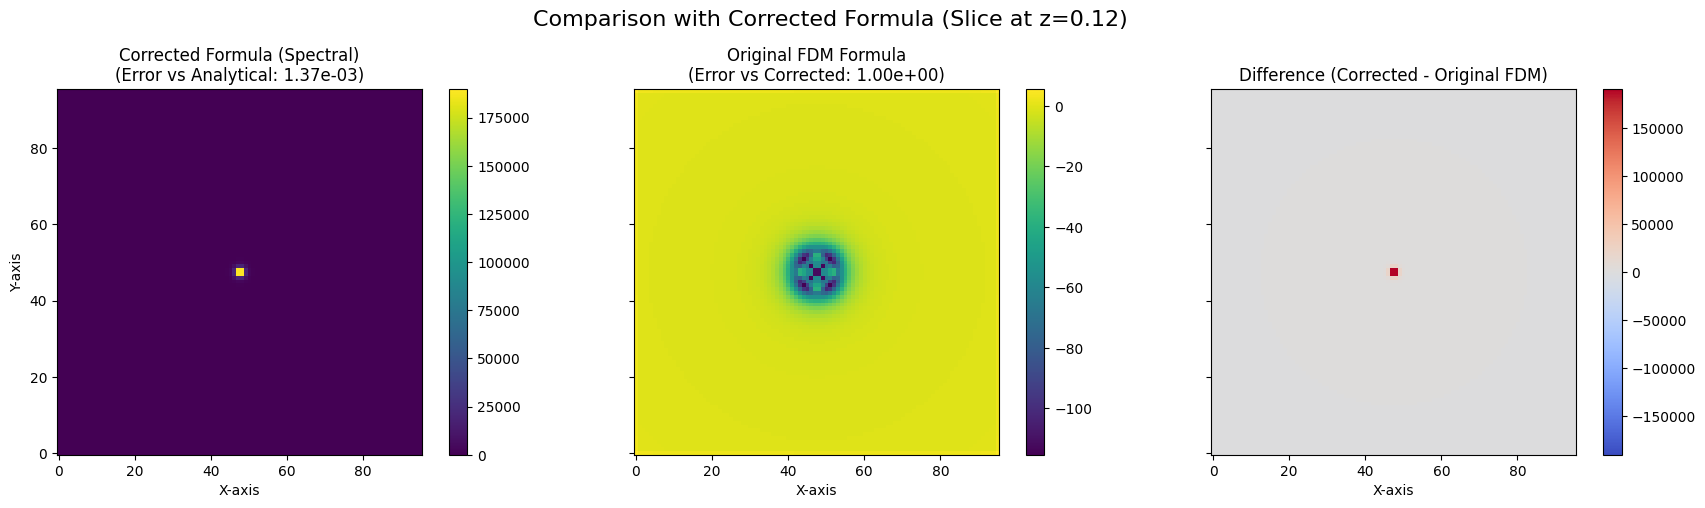

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# 1. GLOBAL PARAMETERS AND GRID SETUP
# ===================================================================
# Nx, Ny, Nz = 64, 64, 64
# dx = 0.5
# mu_z = 1.0

ix, iy, iz = jnp.meshgrid(
    jnp.arange(Nx), jnp.arange(Ny), jnp.arange(Nz), indexing='ij'
)
x = (ix - Nx / 2 + 0.5) * dx
y = (iy - Ny / 2 + 0.5) * dx
z = (iz - Nz / 2 + 0.5) * dx

kx_vec = 2 * jnp.pi * jnp.fft.fftfreq(Nx, d=dx)
ky_vec = 2 * jnp.pi * jnp.fft.fftfreq(Ny, d=dx)
kz_vec = 2 * jnp.pi * jnp.fft.fftfreq(Nz, d=dx)
kx, ky, kz = jnp.meshgrid(kx_vec, ky_vec, kz_vec, indexing='ij')


# ===================================================================
# 2. METHOD DEFINITIONS
# ===================================================================

# --- Method A: Your Original Finite-Difference Method (UNCHANGED) ---
# NOTE: This method approximates (∇+iA)²ψ = (∇² + 2iA⋅∇ - A²)ψ
# @jax.jit
# def phase_link_vectorized_jax(direction, Delta_shape):
#     Nx_l, Ny_l, Nz_l, _ = Delta_shape
#     ix_l, iy_l, iz_l = jnp.meshgrid(jnp.arange(Nx_l), jnp.arange(Ny_l), jnp.arange(Nz_l), indexing='ij')
#     x_l, y_l, z_l = (ix_l - Nx_l / 2 + 0.5) * dx, (iy_l - Ny_l / 2 + 0.5) * dx, (iz_l - Nz_l / 2 + 0.5) * dx

#     if direction == 'x': xn, yn, zn = x_l + dx/2, y_l, z_l
#     elif direction == 'y': xn, yn, zn = x_l, y_l + dx/2, z_l
#     else: xn, yn, zn = x_l, y_l, z_l + dx/2

#     r_sq = xn**2 + yn**2 + zn**2
#     r_1_5 = jnp.where(r_sq < 1e-12, 0.0, 1.0 / (r_sq**1.5 + 1e-12))
#     Ax, Ay = -mu_z * yn * r_1_5, mu_z * xn * r_1_5

#     if direction == 'x': alpha = Ax * dx
#     elif direction == 'y': alpha = Ay * dx
#     else: alpha = jnp.zeros_like(Ax)
#     return alpha

@jax.jit
def compute_residual_fdm_jax(Delta):
    psi = Delta[...,0] + 1j*Delta[...,1]
    laplacian_term = jnp.zeros_like(psi)
    alphas = [phase_link_vectorized_jax(d, Delta) for d in ['x', 'y', 'z']]

    for d, alpha_d in enumerate(alphas):
        psi_fwd, psi_bwd = jnp.roll(psi, -1, d), jnp.roll(psi, 1, d)
        alpha_d_bwd = jnp.roll(alpha_d, 1, d)
        term_fwd, term_bwd = jnp.exp(-1j * alpha_d) * psi_fwd, jnp.exp(1j * alpha_d_bwd) * psi_bwd
        laplacian_term += (term_fwd + term_bwd - 2*psi)

    laplacian_term /= dx**2
    residual = laplacian_term - psi + psi * jnp.abs(psi)**2
    return residual / jnp.abs(psi)

# --- Method B: Spectral (FFT) Method (UPDATED WITH NEW SIGNS) ---
@jax.jit
def get_vector_potential(x, y, z, mu_z):
    r_sq = x**2 + y**2 + z**2
    r_3 = jnp.where(r_sq < 1e-12, 0.0, 1.0 / (r_sq**1.5 + 1e-12))
    Ax, Ay, Az = -mu_z * y * r_3, mu_z * x * r_3, jnp.zeros_like(x)
    return jnp.array([Ax, Ay, Az])

@jax.jit
def compute_residual_spectral_corrected_jax(Delta, A, kx, ky, kz):
    """Computes the GL residual using the user's corrected formula."""
    psi = Delta[...,0] + 1j*Delta[...,1]
    fft_psi = jnp.fft.fftn(psi)

    # Term 1: -∇²ψ
    neg_laplacian_psi = jnp.fft.ifftn( (kx**2 + ky**2 + kz**2) * fft_psi )

    # Term 2: 2iA⋅∇ψ (NO CHANGE)
    grad_psi_x = jnp.fft.ifftn(1j * kx * fft_psi)
    grad_psi_y = jnp.fft.ifftn(1j * ky * fft_psi)
    grad_psi_z = jnp.fft.ifftn(1j * kz * fft_psi)
    adot_grad_psi = 2j * (A[0]*grad_psi_x + A[1]*grad_psi_y + A[2]*grad_psi_z)

    # Term 3: +A²ψ
    A_sq_psi = (A[0]**2 + A[1]**2 + A[2]**2) * psi

    # Assemble the kinetic part using the corrected formula
    kinetic_term = neg_laplacian_psi + adot_grad_psi + A_sq_psi

    # Full residual
    residual = kinetic_term - psi + psi * jnp.abs(psi)**2
    return residual / jnp.abs(psi)

# --- Method C: Analytical Solution (UPDATED WITH NEW SIGNS) ---
@jax.jit
def compute_residual_analytical_corrected(x, y, z, sigma, mu_z):
    """Computes the analytical residual for ψ = exp(-r²/2σ²) using the corrected formula."""
    psi = jnp.exp(-(x**2 + y**2 + z**2) / (2 * sigma**2))
    r_sq = x**2 + y**2 + z**2

    # For a radial psi, A⋅∇ψ is zero.
    # We only need to assemble the other terms with the corrected signs.

    # -∇²ψ term
    neg_laplacian_psi = -(r_sq / sigma**4 - 3 / sigma**2) * psi

    # +A²ψ term
    r_6 = jnp.where(r_sq < 1e-12, 0.0, 1.0 / (r_sq**3 + 1e-12))
    A_sq_psi = (mu_z**2 * (x**2 + y**2) * r_6) * psi

    # Assemble the kinetic part
    kinetic_term = neg_laplacian_psi + A_sq_psi

    # Full residual
    residual = kinetic_term - psi + psi * jnp.abs(psi)**2
    return residual / jnp.abs(psi)


# ===================================================================
# 3. TEST EXECUTION AND COMPARISON
# ===================================================================

# if __name__ == '__main__':
# --- Define a test case: a smooth Gaussian profile ---
sigma_gauss = dx * (Nx / 6.0)
psi_gauss = jnp.exp(-(x**2 + y**2 + z**2) / (2 * sigma_gauss**2))
Delta_gauss = jnp.stack([jnp.real(psi_gauss), jnp.imag(psi_gauss)], axis=-1)

A_vec = get_vector_potential(x, y, z, mu_z)

# --- Run all three methods ---
print(f"Running calculations on a {Nx}x{Ny}x{Nz} grid...")

# Corrected Analytical (our new ground truth)
res_analytical_corr = compute_residual_analytical_corrected(x, y, z, sigma_gauss, mu_z)
print("1. Corrected Analytical solution computed.")

# Corrected Spectral Method
res_spectral_corr = compute_residual_spectral_corrected_jax(Delta_gauss, A_vec, kx, ky, kz)
print("2. Corrected Spectral method solution computed.")

# Original Finite-Difference Method
res_fdm_orig = compute_residual_fdm_jax(Delta_gauss)
print("3. Original Finite-difference method solution computed.")

# --- Compare the results ---
error_spectral_vs_analytical = jnp.linalg.norm(res_spectral_corr - res_analytical_corr) / jnp.linalg.norm(res_analytical_corr)
error_fdm_vs_analytical = jnp.linalg.norm(res_fdm_orig - res_analytical_corr) / jnp.linalg.norm(res_analytical_corr)

# --- Print findings ---
print("\n--- Findings ---")
print(f"The FDM code calculates (∇²+2iA⋅∇-A²)ψ, while Spectral/Analytical now calculate (-∇²+2iA⋅∇+A²)ψ.")
print(f"Relative Error of Corrected Spectral vs Corrected Analytical: {error_spectral_vs_analytical:.4e}")
print(f"Relative Error of Original FDM vs Corrected Analytical:     {error_fdm_vs_analytical:.4e}")

# --- Visualize the results ---
z_slice = Nz // 2
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
slice_z_coord = z[0, 0, z_slice]
fig.suptitle(f"Comparison with Corrected Formula (Slice at z={slice_z_coord:.2f})", fontsize=16)

# Plot 1: Corrected Analytical/Spectral
im0 = axes[0].imshow(np.array(np.real(res_spectral_corr[:, :, z_slice])), cmap='viridis', origin='lower')
axes[0].set_title(f"Corrected Formula (Spectral)\n(Error vs Analytical: {error_spectral_vs_analytical:.2e})")
axes[0].set_ylabel("Y-axis"); axes[0].set_xlabel("X-axis")
fig.colorbar(im0, ax=axes[0])

# Plot 2: Original FDM
im1 = axes[1].imshow(np.array(np.real(res_fdm_orig[:, :, z_slice])), cmap='viridis', origin='lower')
axes[1].set_title(f"Original FDM Formula\n(Error vs Corrected: {error_fdm_vs_analytical:.2e})")
axes[1].set_xlabel("X-axis")
fig.colorbar(im1, ax=axes[1])

# Plot 3: Difference between the two formulas
diff = np.array(np.real(res_spectral_corr - res_fdm_orig))
vmax = np.max(np.abs(diff))
im2 = axes[2].imshow(diff[:, :, z_slice], cmap='coolwarm', origin='lower', vmin=-vmax, vmax=vmax)
axes[2].set_title("Difference (Corrected - Original FDM)")
axes[2].set_xlabel("X-axis")
fig.colorbar(im2, ax=axes[2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
spec_residual_init = compute_residual_spectral_corrected_jax(Delta_init, A_vec, kx, ky, kz)
spec_residual = compute_residual_spectral_corrected_jax(Delta_final, A_vec, kx, ky, kz)

jnp.abs(spec_residual_init).max()

Array(inf, dtype=float32)

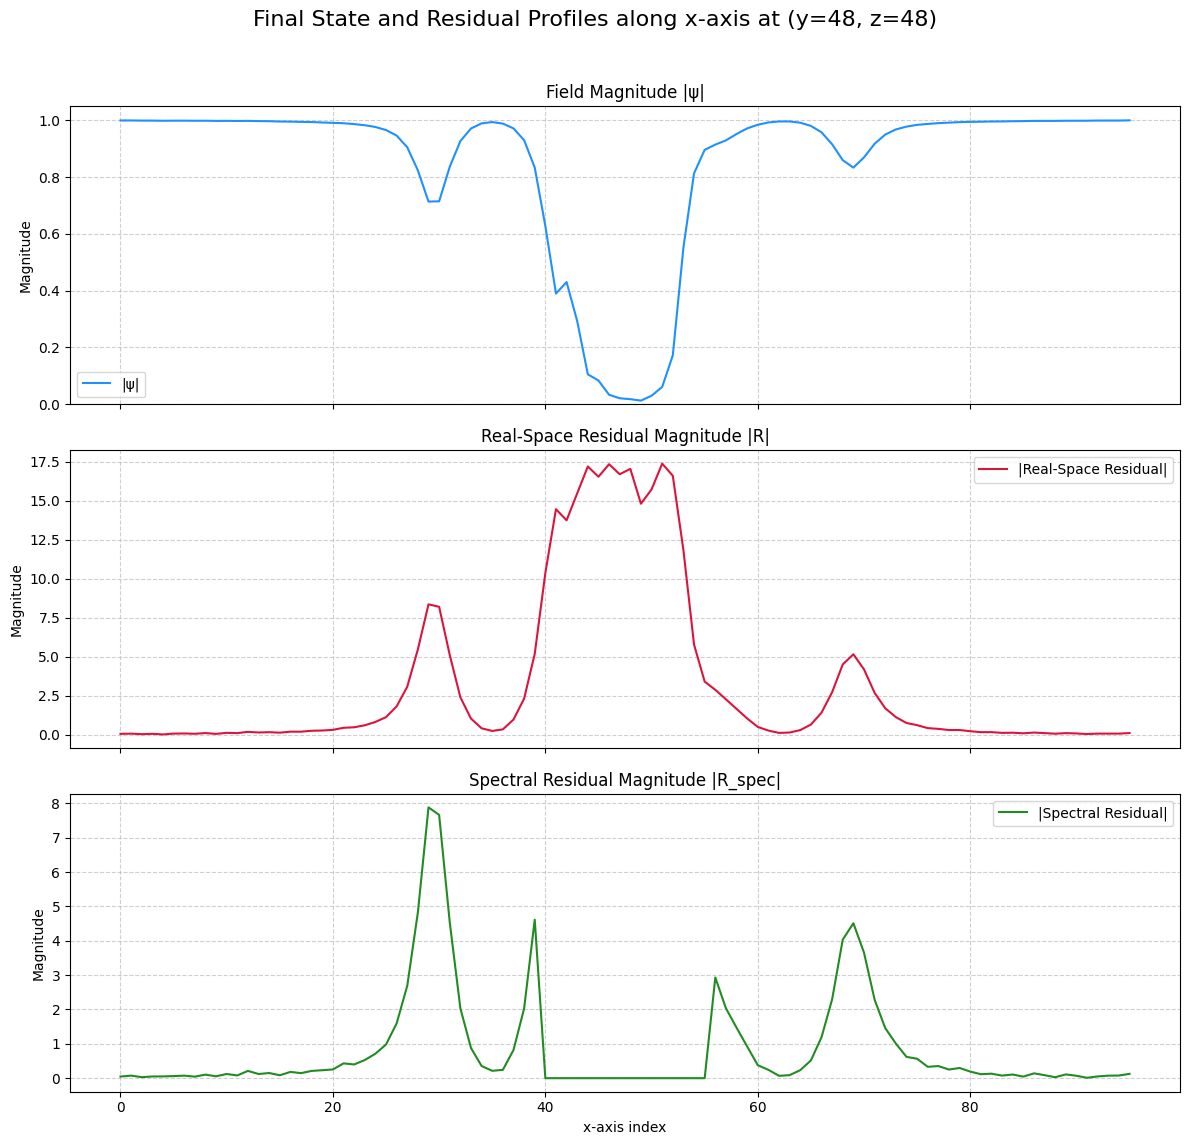

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# --- Data Preparation for 1D Slice ---

# 1. Select the line through the middle of the volume
y_slice = Ny // 2
z_slice = Nz // 2

# 2. Extract the 1D data slices along the x-axis
# Get the complex field psi
psi_final = Delta_final[..., 0] + 1j * Delta_final[..., 1]

# Get the magnitude of the field along the line
psi_final_mag_slice = np.array(jnp.abs(psi_final[:, y_slice, z_slice]))

# Get the magnitude of the real-space residual along the line
res_final_slice = np.array(jnp.abs(residual[:, y_slice, z_slice]))

# Get the magnitude of the spectral residual along the line
spec_res_slice = np.array(jnp.abs(spec_residual[:, y_slice, z_slice]))
spec_res_slice[y_slice - 8: y_slice + 8] = 0.0

# --- Visualization of 1D Slices ---

# 3. Create a figure with three stacked subplots
# sharex=True links the x-axes of the plots for easier comparison.
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig.suptitle(f'Final State and Residual Profiles along x-axis at (y={y_slice}, z={z_slice})', fontsize=16)

# --- Top Plot: Field Magnitude |ψ| ---
axes[0].plot(psi_final_mag_slice, label='|ψ|', color='dodgerblue')
axes[0].set_title('Field Magnitude |ψ|')
axes[0].set_ylabel('Magnitude')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()
axes[0].set_ylim(bottom=0) # Set y-axis to start from 0

# --- Middle Plot: Real-Space Residual Magnitude |R| ---
axes[1].plot(res_final_slice, label='|Real-Space Residual|', color='crimson')
axes[1].set_title('Real-Space Residual Magnitude |R|')
axes[1].set_ylabel('Magnitude')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

# --- Bottom Plot: Spectral Residual Magnitude |R_spec| ---
axes[2].plot(spec_res_slice, label='|Spectral Residual|', color='forestgreen')
axes[2].set_title('Spectral Residual Magnitude |R_spec|')
axes[2].set_xlabel('x-axis index') # X-label only on the bottom plot
axes[2].set_ylabel('Magnitude')
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].legend()

# 4. Adjust layout and show the final result
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust for suptitle
plt.savefig('x-line_slice_with_spec_residual.png')
plt.show()

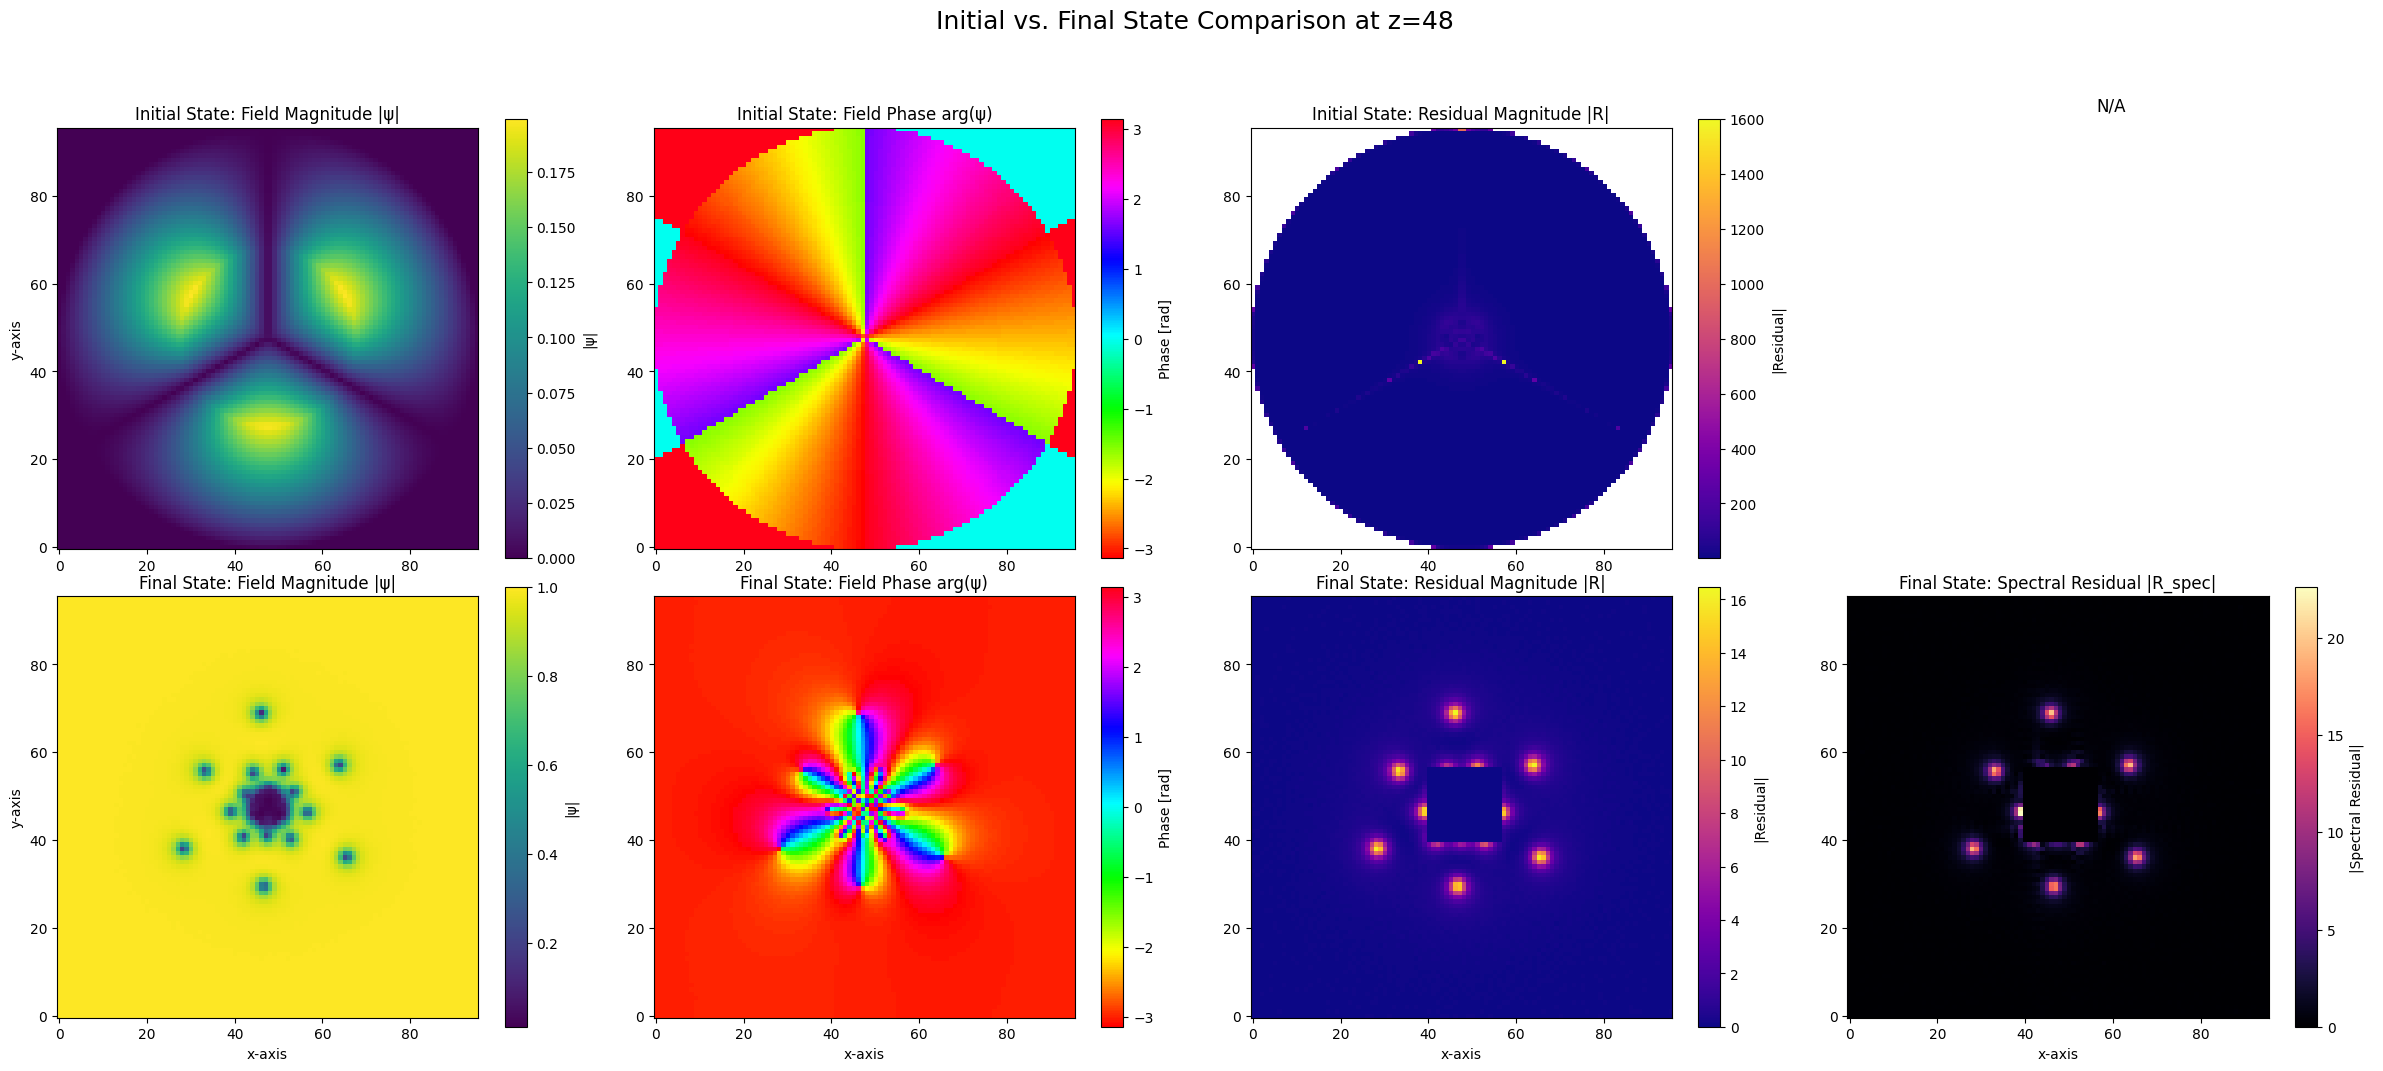

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming jnp, Delta_init, Delta_final, residual_init, residual,
# spec_residual, Nx, Ny, Nz are all pre-defined from your simulation.

# --- Visualization ---

# 1. Select the slice through the middle of the volume
z_slice = Nz // 2

# === Prepare Data Slices for Plotting ===

# --- Initial State Slices ---
psi_init = Delta_init[..., 0] + 1j * Delta_init[..., 1]
psi_init_mag_slice = np.array(jnp.abs(psi_init[:, :, z_slice]))
psi_init_phase_slice = np.array(jnp.angle(psi_init[:, :, z_slice]))
res_init_slice = np.array(jnp.abs(residual_init[:, :, z_slice]))

# --- Final State Slices ---
psi_final = Delta_final[..., 0] + 1j * Delta_final[..., 1]
psi_final_mag_slice = np.array(jnp.abs(psi_final[:, :, z_slice]))
psi_final_phase_slice = np.array(jnp.angle(psi_final[:, :, z_slice]))
res_final_slice = np.array(jnp.abs(residual[:, :, z_slice]))

# --- Final Spectral Residual Slice (NEW) ---
spec_res_slice = np.array(jnp.abs(spec_residual[:, :, z_slice]))


# === Create Mask for Visual Clarity ===
# This mask hides the noisy central region for certain plots.
a = 8
center_x, center_y = Nx // 2, Ny // 2
y_min, y_max = center_y - a, center_y + a
x_min, x_max = center_x - a, center_x + a
plot_mask = np.zeros_like(psi_init_mag_slice, dtype=bool)
plot_mask[y_min : y_max + 1, x_min : x_max + 1] = True

# --- Apply Masks ---
psi_init_phase_masked = psi_init_phase_slice.copy()
# psi_init_phase_masked[plot_mask] = 0.0 # Example of masking if needed

psi_final_phase_masked = psi_final_phase_slice.copy()
# psi_final_phase_masked[plot_mask] = 0.0 # Example of masking if needed

# Mask the final real-space residual
psi_final_res_masked = res_final_slice.copy()
psi_final_res_masked[plot_mask] = 0.0

# Mask the final spectral residual (NEW)
spec_res_final_masked = spec_res_slice.copy()
spec_res_final_masked[plot_mask] = 0.0


# 2. Create the 2x4 plot grid (UPDATED)
fig, axes = plt.subplots(2, 4, figsize=(24, 11)) # Increased size for new column
fig.suptitle(f'Initial vs. Final State Comparison at z={z_slice}', fontsize=18)

# --- Top Row: Initial State ---

# Top-Left: Initial |ψ|
im1 = axes[0, 0].imshow(psi_init_mag_slice, origin='lower', cmap='viridis')
axes[0, 0].set_title('Initial State: Field Magnitude |ψ|')
axes[0, 0].set_ylabel('y-axis')
fig.colorbar(im1, ax=axes[0, 0], label='|ψ|')

# Top-Middle: Initial arg(ψ)
im2 = axes[0, 1].imshow(psi_init_phase_masked, origin='lower', cmap='hsv')
axes[0, 1].set_title('Initial State: Field Phase arg(ψ)')
fig.colorbar(im2, ax=axes[0, 1], label='Phase [rad]')

# Top-Right: Initial Residual
im3 = axes[0, 2].imshow(res_init_slice, origin='lower', cmap='plasma')
axes[0, 2].set_title('Initial State: Residual Magnitude |R|')
fig.colorbar(im3, ax=axes[0, 2], label='|Residual|')

# Top-Far-Right: Empty plot (UPDATED)
axes[0, 3].axis('off') # Turn off axis for this empty subplot
axes[0, 3].set_title('N/A')


# --- Bottom Row: Final State ---

# Bottom-Left: Final |ψ|
im4 = axes[1, 0].imshow(psi_final_mag_slice, origin='lower', cmap='viridis')
axes[1, 0].set_title('Final State: Field Magnitude |ψ|')
axes[1, 0].set_xlabel('x-axis')
axes[1, 0].set_ylabel('y-axis')
fig.colorbar(im4, ax=axes[1, 0], label='|ψ|')

# Bottom-Middle: Final arg(ψ)
im5 = axes[1, 1].imshow(psi_final_phase_masked, origin='lower', cmap='hsv')
axes[1, 1].set_title('Final State: Field Phase arg(ψ)')
axes[1, 1].set_xlabel('x-axis')
fig.colorbar(im5, ax=axes[1, 1], label='Phase [rad]')

# Bottom-Right: Final Residual
im6 = axes[1, 2].imshow(psi_final_res_masked, origin='lower', cmap='plasma')
axes[1, 2].set_title('Final State: Residual Magnitude |R|')
axes[1, 2].set_xlabel('x-axis')
fig.colorbar(im6, ax=axes[1, 2], label='|Residual|')

# Bottom-Far-Right: Final Spectral Residual (NEW)
im7 = axes[1, 3].imshow(spec_res_final_masked, origin='lower', cmap='magma')
axes[1, 3].set_title('Final State: Spectral Residual |R_spec|')
axes[1, 3].set_xlabel('x-axis')
fig.colorbar(im7, ax=axes[1, 3], label='|Spectral Residual|')


# 3. Adjust layout and show the final result
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.savefig('z-slice_masked_with_spec_residual.png')
plt.show()

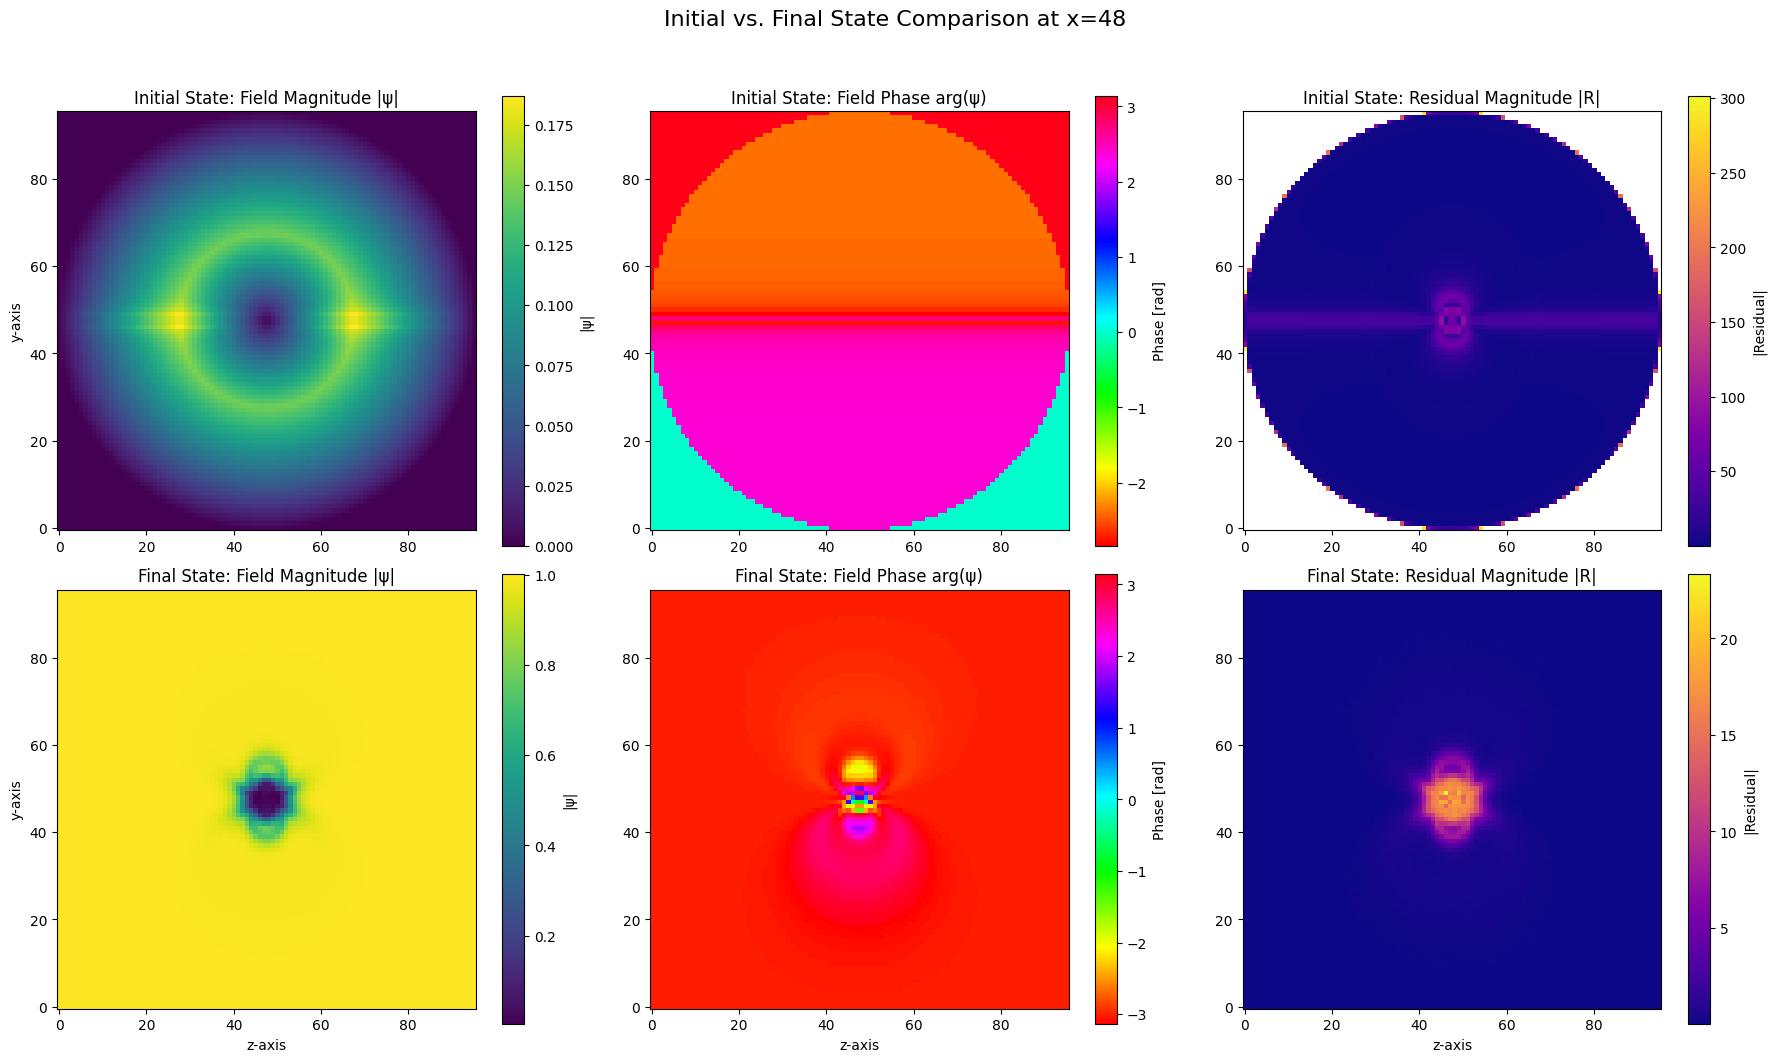

In [ ]:
# --- Visualization ---

# 1. Select the slice through the middle of the volume (e.g., z=16 for a size of 32)
# Using a value like 50 would be out of bounds for the defined grid size.
# z_slice = Nz // 2 - 20
x_slice = Nz // 2

# === Prepare Data Slices for Plotting ===

# --- Initial State Slices ---
# Get the complex field psi = Delta_real + i*Delta_imag
psi_init = Delta_init[..., 0] + 1j * Delta_init[..., 1]
# Get the magnitude of the field
psi_init_mag_slice = np.array(jnp.abs(psi_init[x_slice, :, :]))
# Get the phase (argument) of the field
psi_init_phase_slice = np.array(jnp.angle(psi_init[x_slice, :, :]))

# Get the magnitude of the residual
res_init_slice = np.array(jnp.abs(residual_init[x_slice, :, :]))

# --- Final State Slices ---
# Get the complex field psi
psi_final = Delta_final[..., 0] + 1j * Delta_final[..., 1]
# Get the magnitude of the field
psi_final_mag_slice = np.array(jnp.abs(psi_final[x_slice, :, :]))
# Get the phase (argument) of the field
psi_final_phase_slice = np.array(jnp.angle(psi_final[x_slice, :, :]))


# Get the magnitude of the residual
# Note: your original code used `residual` which was the final residual. I'll rename it for clarity.
res_final = residual # Renaming for clarity from the original script
res_final_slice = np.array(jnp.abs(res_final[x_slice, :, :]))


# 2. Create the 2x3 plot grid
# The `axes` object will be a 2D numpy array with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle(f'Initial vs. Final State Comparison at x={x_slice}', fontsize=16)

# --- Top Row: Initial State ---

# Top-Left: Initial |ψ|
im1 = axes[0, 0].imshow(psi_init_mag_slice, origin='lower', cmap='viridis')
axes[0, 0].set_title('Initial State: Field Magnitude |ψ|')
axes[0, 0].set_ylabel('y-axis')
fig.colorbar(im1, ax=axes[0, 0], label='|ψ|')

# Top-Middle: Initial arg(ψ)
im2 = axes[0, 1].imshow(psi_init_phase_slice, origin='lower', cmap='hsv')
axes[0, 1].set_title('Initial State: Field Phase arg(ψ)')
fig.colorbar(im2, ax=axes[0, 1], label='Phase [rad]')

# Top-Right: Initial Residual
im3 = axes[0, 2].imshow(res_init_slice, origin='lower', cmap='plasma')
axes[0, 2].set_title('Initial State: Residual Magnitude |R|')
fig.colorbar(im3, ax=axes[0, 2], label='|Residual|')


# --- Bottom Row: Final State ---

# Bottom-Left: Final |ψ|
im4 = axes[1, 0].imshow(psi_final_mag_slice, origin='lower', cmap='viridis')
axes[1, 0].set_title('Final State: Field Magnitude |ψ|')
axes[1, 0].set_xlabel('z-axis')
axes[1, 0].set_ylabel('y-axis')
fig.colorbar(im4, ax=axes[1, 0], label='|ψ|')

# Bottom-Middle: Final arg(ψ)
im5 = axes[1, 1].imshow(psi_final_phase_slice, origin='lower', cmap='hsv')
axes[1, 1].set_title('Final State: Field Phase arg(ψ)')
axes[1, 1].set_xlabel('z-axis')
fig.colorbar(im5, ax=axes[1, 1], label='Phase [rad]')

# Bottom-Right: Final Residual
im6 = axes[1, 2].imshow(res_final_slice, origin='lower', cmap='plasma')
axes[1, 2].set_title('Final State: Residual Magnitude |R|')
axes[1, 2].set_xlabel('z-axis')
fig.colorbar(im6, ax=axes[1, 2], label='|Residual|')


# 3. Adjust layout and show the final result
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.savefig('x-slice.png')

plt.show()

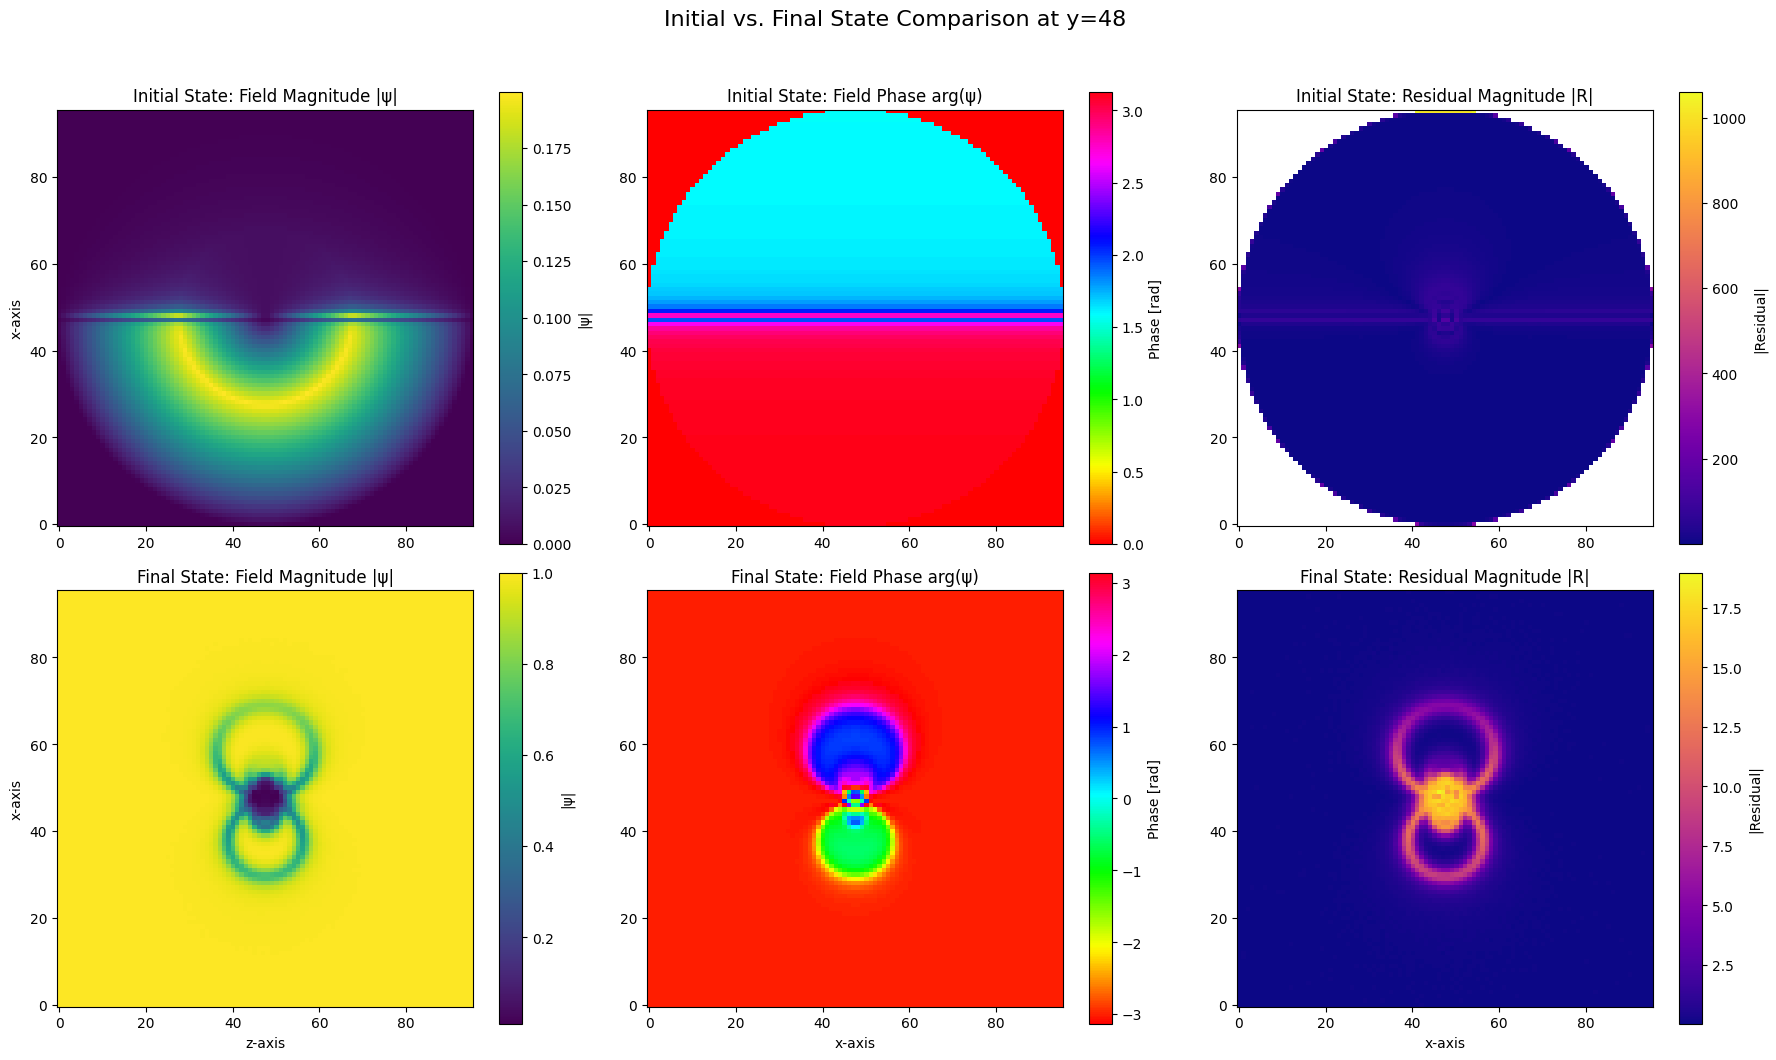

In [ ]:
# --- Visualization ---

# 1. Select the slice through the middle of the volume (e.g., z=16 for a size of 32)
# Using a value like 50 would be out of bounds for the defined grid size.
# z_slice = Nz // 2 - 20
# x_slice = Nz // 2
y_slice = Nz // 2


# === Prepare Data Slices for Plotting ===

# --- Initial State Slices ---
# Get the complex field psi = Delta_real + i*Delta_imag
psi_init = Delta_init[..., 0] + 1j * Delta_init[..., 1]
# Get the magnitude of the field
psi_init_mag_slice = np.array(jnp.abs(psi_init[:, y_slice, :]))
# Get the phase (argument) of the field
psi_init_phase_slice = np.array(jnp.angle(psi_init[:, y_slice, :]))

# Get the magnitude of the residual
res_init_slice = np.array(jnp.abs(residual_init[:, y_slice, :]))

# --- Final State Slices ---
# Get the complex field psi
psi_final = Delta_final[..., 0] + 1j * Delta_final[..., 1]
# Get the magnitude of the field
psi_final_mag_slice = np.array(jnp.abs(psi_final[:, y_slice, :]))
# Get the phase (argument) of the field
psi_final_phase_slice = np.array(jnp.angle(psi_final[:, y_slice, :]))


# Get the magnitude of the residual
# Note: your original code used `residual` which was the final residual. I'll rename it for clarity.
res_final = residual # Renaming for clarity from the original script
res_final_slice = np.array(jnp.abs(res_final[:, y_slice, :]))


# 2. Create the 2x3 plot grid
# The `axes` object will be a 2D numpy array with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle(f'Initial vs. Final State Comparison at y={y_slice}', fontsize=16)

# --- Top Row: Initial State ---

# Top-Left: Initial |ψ|
im1 = axes[0, 0].imshow(psi_init_mag_slice, origin='lower', cmap='viridis')
axes[0, 0].set_title('Initial State: Field Magnitude |ψ|')
axes[0, 0].set_ylabel('x-axis')
fig.colorbar(im1, ax=axes[0, 0], label='|ψ|')

# Top-Middle: Initial arg(ψ)
im2 = axes[0, 1].imshow(psi_init_phase_slice, origin='lower', cmap='hsv')
axes[0, 1].set_title('Initial State: Field Phase arg(ψ)')
fig.colorbar(im2, ax=axes[0, 1], label='Phase [rad]')

# Top-Right: Initial Residual
im3 = axes[0, 2].imshow(res_init_slice, origin='lower', cmap='plasma')
axes[0, 2].set_title('Initial State: Residual Magnitude |R|')
fig.colorbar(im3, ax=axes[0, 2], label='|Residual|')


# --- Bottom Row: Final State ---

# Bottom-Left: Final |ψ|
im4 = axes[1, 0].imshow(psi_final_mag_slice, origin='lower', cmap='viridis')
axes[1, 0].set_title('Final State: Field Magnitude |ψ|')
axes[1, 0].set_xlabel('z-axis')
axes[1, 0].set_ylabel('x-axis')
fig.colorbar(im4, ax=axes[1, 0], label='|ψ|')

# Bottom-Middle: Final arg(ψ)
im5 = axes[1, 1].imshow(psi_final_phase_slice, origin='lower', cmap='hsv')
axes[1, 1].set_title('Final State: Field Phase arg(ψ)')
axes[1, 1].set_xlabel('x-axis')
fig.colorbar(im5, ax=axes[1, 1], label='Phase [rad]')

# Bottom-Right: Final Residual
im6 = axes[1, 2].imshow(res_final_slice, origin='lower', cmap='plasma')
axes[1, 2].set_title('Final State: Residual Magnitude |R|')
axes[1, 2].set_xlabel('x-axis')
fig.colorbar(im6, ax=axes[1, 2], label='|Residual|')


# 3. Adjust layout and show the final result
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.savefig('y-slice.png')

plt.show()

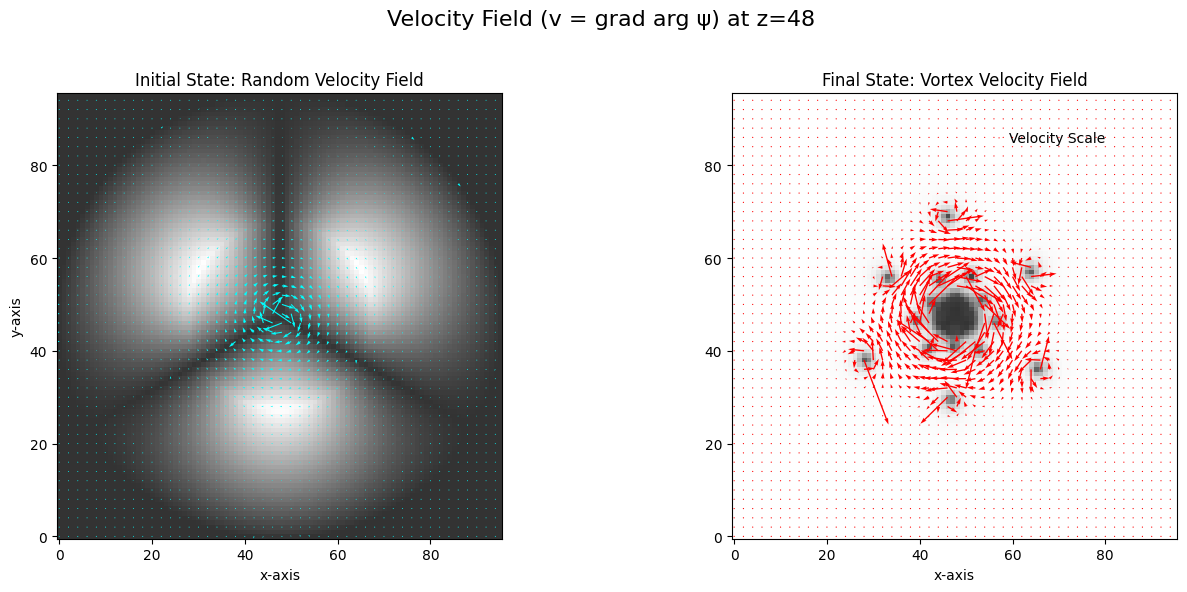

In [ ]:
@jax.jit
def compute_velocity_field(Delta):
    """
    Computes the velocity field v = Im(psi* grad(psi)) / |psi|^2.
    This avoids phase wrapping issues.
    """
    psi = Delta[..., 0] + 1j * Delta[..., 1]

    # Compute gradients of the complex field psi using central differences
    # d(psi)/dx
    psi_fwd_x = jnp.roll(psi, shift=-1, axis=1)
    psi_bwd_x = jnp.roll(psi, shift=1, axis=1)
    grad_psi_x = (psi_fwd_x - psi_bwd_x) / (2 * dx)

    # d(psi)/dy
    psi_fwd_y = jnp.roll(psi, shift=-1, axis=0)
    psi_bwd_y = jnp.roll(psi, shift=1, axis=0)
    grad_psi_y = (psi_fwd_y - psi_bwd_y) / (2 * dx) # Assuming dy=dx

    # Compute |psi|^2, adding a small epsilon to avoid division by zero at the core
    abs_psi_sq = jnp.abs(psi)**2
    epsilon = 1e-8

    # Pre-compute all alpha phases once for efficiency
    alpha_x = phase_link_vectorized_jax('x', Delta)
    alpha_y = phase_link_vectorized_jax('y', Delta)
    alpha_z = phase_link_vectorized_jax('z', Delta)
    # alphas = [alpha_x, alpha_y, alpha_z]

    # Apply the formula v = Im(conj(psi) * grad(psi)) / |psi|^2
    v_x = jnp.imag(jnp.conj(psi) * grad_psi_x) / (abs_psi_sq + epsilon)
    v_y = jnp.imag(jnp.conj(psi) * grad_psi_y) / (abs_psi_sq + epsilon)
    # v_x += alpha_x / dx
    # v_y += alpha_y / dx
    return v_x, v_y

# --- Computation ---
# Compute velocity fields
vx_init, vy_init = compute_velocity_field(Delta_init)
vx_final, vy_final = compute_velocity_field(Delta_final)


# --- Visualization of Velocity Fields ---

# 1. Select the slice and prepare data
z_slice = Nz // 2

# Get the magnitude of the psi field for background context
psi_init = Delta_init[..., 0] + 1j * Delta_init[..., 1]
psi_final = Delta_final[..., 0] + 1j * Delta_final[..., 1]
psi_init_slice = np.array(jnp.abs(psi_init[:, :, z_slice]))
psi_final_slice = np.array(jnp.abs(psi_final[:, :, z_slice]))

# Get the velocity field slices
vx_init_slice = np.array(vx_init[:, :, z_slice])
vy_init_slice = np.array(vy_init[:, :, z_slice])
vx_final_slice = np.array(vx_final[:, :, z_slice])
vy_final_slice = np.array(vy_final[:, :, z_slice])


# 2. Create the plots using a quiver plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Velocity Field (v = grad arg ψ) at z={z_slice}', fontsize=16)

# --- Plot for the Initial State ---

# To avoid a messy plot, we'll only plot a vector every few grid points
skip = 2
X_grid, Y_grid = np.meshgrid(np.arange(Nx), np.arange(Ny))

ax1.set_title('Initial State: Random Velocity Field')
# Plot the magnitude |psi| as a background
im1 = ax1.imshow(psi_init_slice, origin='lower', cmap='gray', alpha=0.8)
# Overlay the vector field
ax1.quiver(X_grid[::skip, ::skip], Y_grid[::skip, ::skip],
           vx_init_slice[::skip, ::skip], vy_init_slice[::skip, ::skip],
           color='cyan', scale=60)
ax1.set_xlabel('x-axis')
ax1.set_ylabel('y-axis')
ax1.set_aspect('equal', adjustable='box')


# --- Plot for the Final State (Vortex) ---

ax2.set_title('Final State: Vortex Velocity Field')
# Plot the magnitude |psi| as a background. Note the dark core where |psi|=0.
im2 = ax2.imshow(psi_final_slice, origin='lower', cmap='gray', alpha=0.8)
# Overlay the vector field
# === KEY CHANGE: CREATE AND APPLY THE MASK ===

# Define the half-width of the square to hide.
# A square of side length (2*a + 1) will be hidden. a=3 gives a 7x7 square.
a = 5
center_x, center_y = Nx // 2, Ny // 2

# 1. Create a boolean mask that is True only for the points we want to plot.
#    Start by selecting the downsampled grid points.
plot_mask = np.zeros_like(psi_final_slice, dtype=bool)
plot_mask[::skip, ::skip] = True

# 2. Now, set the central square region in the mask to False to exclude it.
y_min, y_max = center_y - a, center_y + a
x_min, x_max = center_x - a, center_x + a
plot_mask[y_min : y_max + 1, x_min : x_max + 1] = False

# 3. Apply the mask to get 1D arrays of the coordinates and velocities to plot.
X_to_plot = X_grid[plot_mask]
Y_to_plot = Y_grid[plot_mask]
U_to_plot = vx_final_slice[plot_mask]
V_to_plot = vy_final_slice[plot_mask]

q = ax2.quiver(X_to_plot, Y_to_plot, U_to_plot, V_to_plot,
               color='red', scale=60, width=0.003)
ax2.set_xlabel('x-axis')
ax2.set_aspect('equal', adjustable='box')

# Add a quiver key to show the scale of the vectors
# This places a reference vector labeled '0.1' in the upper right
ax2.quiverkey(q, X=0.6, Y=0.9, U=0.1,
              label='Velocity Scale', labelpos='E')


# 3. Show the final result
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('velocity_field_z_slice.png')
plt.show()

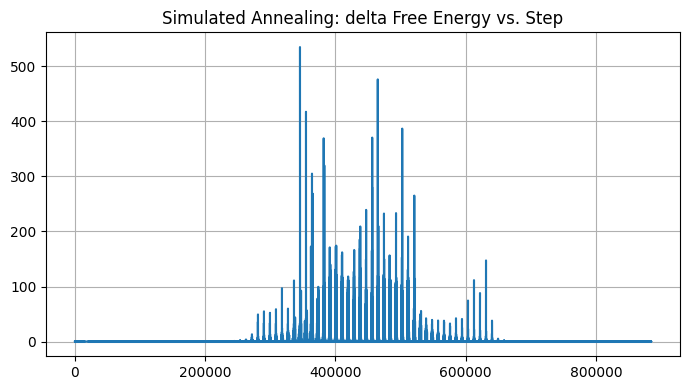

Array(43510.863+7309.8906j, dtype=complex64)

In [ ]:
import matplotlib.pyplot as plt

def plot_energy_trace(residual):
    plt.figure(figsize=(7,4))
    plt.plot(jnp.abs(residual).ravel())
    # plt.xlabel('Annealing Step')
    # plt.ylabel('Free Energy')
    plt.title('Simulated Annealing: delta Free Energy vs. Step')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage after annealing:
plot_energy_trace(residual)
residual.sum()

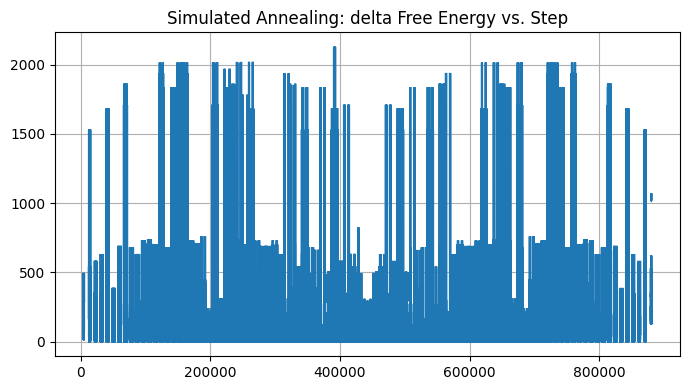

Array(nan+nanj, dtype=complex64)

In [ ]:
import matplotlib.pyplot as plt

def plot_energy_trace(residual):
    plt.figure(figsize=(7,4))
    plt.plot(jnp.abs(residual).ravel())
    # plt.xlabel('Annealing Step')
    # plt.ylabel('Free Energy')
    plt.title('Simulated Annealing: delta Free Energy vs. Step')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage after annealing:
plot_energy_trace(residual_init)
residual_init.sum()


In [ ]:
# import matplotlib.pyplot as plt

# def plot_energy_trace(energy_trace):
#     plt.figure(figsize=(7,4))
#     plt.plot(energy_trace)
#     plt.xlabel('Annealing Step')
#     plt.ylabel('Free Energy')
#     plt.title('Simulated Annealing: Free Energy vs. Step')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Usage after annealing:
# plot_energy_trace(energy_trace)


In [ ]:
import numpy as np
import pyvista as pv
import ipywidgets as widgets
from ipywidgets import interact

# pv.set_jupyter_backend('trame')

# pv.start_xvfb()

def plot_isosurface_pyvista(Delta_final, dx=1.0, isovalue_fraction=0.2, save=False):
    # Slice to exclude 3 points at each end along each axis
    sub_n = 4
    # Delta_sub = Delta_final[sub_n:-sub_n, sub_n:-sub_n, sub_n:-sub_n, :]
    Delta_sub = Delta_final[:, :, :, :]

    Nx, Ny, Nz, _ = Delta_sub.shape

    psi_sq = Delta_sub[..., 0]**2 + Delta_sub[..., 1]**2
    psi_sq_max = psi_sq.max()
    iso_value = isovalue_fraction * psi_sq_max

    grid = pv.ImageData()
    grid.dimensions = np.array(psi_sq.shape)
    grid.spacing = (dx, dx, dx)

    grid.point_data["psi_sq"] = psi_sq.flatten(order="F")

    contour_surf = grid.contour([iso_value], scalars="psi_sq")

    plotter = pv.Plotter(notebook=True)
    plotter.add_mesh(contour_surf, color="red", opacity=1)
    plotter.add_axes()
    plotter.show_bounds()
    if save:
        plotter.export_html(f"Delta_final_{mu_z}_{Nx*Ny*Nz}_{dx}.html")
    return plotter.show(jupyter_backend="html", return_viewer=True)


# Interactive function using ipywidgets slider
def interactive_plot(isovalue_fraction):
    plot_isosurface_pyvista(Delta_init, dx=1.0, isovalue_fraction=isovalue_fraction)

# Create interactive slider (from 0 to 1, step of 0.01)
# interact(interactive_plot, isovalue_fraction=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.3))
# viewer = plot_isosurface_pyvista(Delta_init, dx=0.5, isovalue_fraction=0.4)
viewer = plot_isosurface_pyvista(Delta_final, dx=0.25, isovalue_fraction=0.5, save=True)
# viewer = plot_isosurface_pyvista(Delta_final, dx=0.5, isovalue_fraction=0.2, save=True)

print(viewer)
viewer

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-type&quot; content=&quot;text/html; charset=utf-8&quot;/>\n    <meta name=&quot;viewport&quot; content=&quot;width=device-width, height=device-height, initial-scale=1, maximum-scale=1, minimum-scale=1, user-scalable=no&quot;>\n  </head>\n  <body>\n    <div class=&quot;content&quot;></div>\n<script type=&quot;text/javascript&quot;>\n!function(){var e={346:function(){const e=document.querySelector(&quot;head&quot;);e&&[16,32,96,160,196].forEach((t=>{const n=document.createElement(&quot;link&quot;);n.setAttribute(&quot;rel&quot;,&quot;icon&quot;),n.setAttribute(&quot;href&quot;,`https://kitware.github.io/vtk-js/icon/favicon-${t}x${t}.png`),n.setAttribute(&quot;sizes&quot;,`${t}x${t}`),n.setAttribute(&quot;type&quot;,&quot;image/png&quot;),e.appendChild(n)}))},422:function(e,t,n){&quot;use strict&quot;;n.r(t),n.d(t,{initLocalFileLoader:function(){return CC},load:function(){return x

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [ ]:
# viewer.

In [ ]:
# import numpy as np
# import jax
# mu_z = 25
# Nx = 6*16
# Ny = 6*16
# Nz = 6*16

# Assuming Delta_final is defined and computed somewhere in your code:
jax.numpy.save(f"Delta_final_true_linear_{mu_z}_{Nx*Ny*Nz}_{dx}.npy", Delta_final)
# Delta_final = jax.numpy.load(f"Delta_final_linear_{mu_z}_{Nx*Ny*Nz}.npy")